## Exploration of Metro Nashville Missed Trash Pickups

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

trash_data = pd.read_csv('../data/trash_hauler_report_with_lat_lng.csv')
trash_data.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE
0,25270,11/1/2017,Trash - Backdoor,"house with the wheel chair ramp, they share driveway, in back driveway. 3817 Crouch Dr near NES light post is. \n615-876-6274",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292
1,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470


**Step 1: Data Preparation**
1. Convert any date columns to datetime using pd.to_datetime().  
2. Create new columns for:  
    * year, month, day
    * day_of_week (or weekday name)
3. Filter the data so that you are only analyzing actual missed pickups.

In [201]:
trash_data['Date Opened'] = pd.to_datetime(trash_data['Date Opened'],
                                           format = "%m/%d/%Y")

In [202]:
trash_data['Year'] = trash_data['Date Opened'].dt.year
trash_data['Month'] = trash_data['Date Opened'].dt.month
trash_data['Day'] = trash_data['Date Opened'].dt.day
trash_data['Date'] = trash_data['Date Opened'].dt.date
trash_data['Weekday'] = trash_data['Date Opened'].dt.day_name()

In [203]:
trash_misses = trash_data[
                    (trash_data['Description'].str.contains('[mM]iss', regex=True).fillna(False))
                    | (trash_data['Request']=='Trash - Curbside/Alley Missed Pickup')
                        ]

/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_74982/3780204410.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (trash_data['Description'].str.contains('[mM]iss', regex=True).fillna(False))


In [204]:
trash_misses.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Date,Weekday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,2017-11-01,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,2017,11,1,2017-11-01,Wednesday


**Step 2: Explore Time-Based Patterns**  
Answer these simpler questions first:  
1. Which day of the week has the highest number of missed pickups?
2. Missed pickups over time:  
    * Find the total number of missed pickups by month. Plot this with a line chart.  
    * Create a plot showing the number of missed pickups per day.  
    * Compute a rolling 30-day average of daily missed pickups. Visualize your results with a line chart to see trends.


In [205]:
trash_misses.value_counts('Weekday').idxmax()

'Thursday'

The day of the week with the highest number of missed pickups is Thursday.

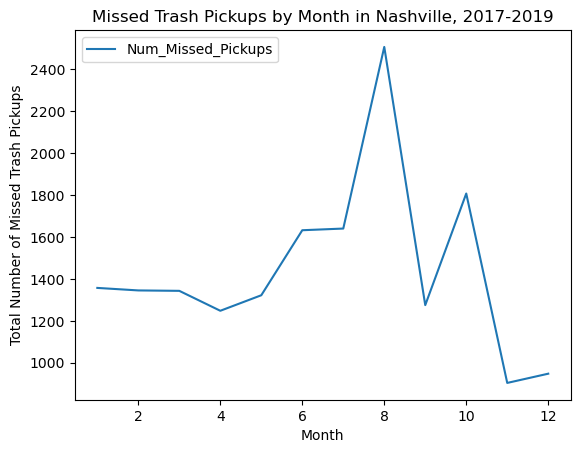

In [206]:
missed_pickups_by_month = trash_misses.groupby('Month').size().reset_index().sort_values(by='Month')

missed_pickups_by_month.columns = ['Month', 'Num_Missed_Pickups']

missed_pickups_by_month.plot(kind='line', x='Month', y='Num_Missed_Pickups')
plt.title('Missed Trash Pickups by Month in Nashville, 2017-2019')
plt.xlabel('Month')
plt.ylabel('Total Number of Missed Trash Pickups')
plt.show()

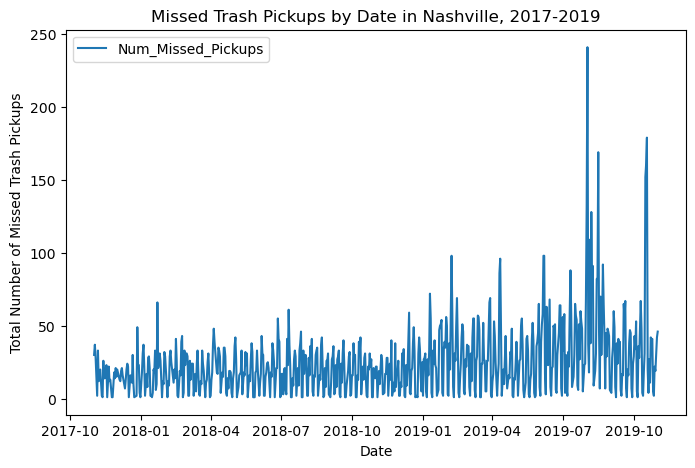

In [207]:
missed_pickups_by_day = trash_misses.groupby('Date').size().reset_index().sort_values(by='Date')
missed_pickups_by_day.columns = ['Date', 'Num_Missed_Pickups']
missed_pickups_by_day.plot(kind='line', x='Date', y='Num_Missed_Pickups', figsize=(8, 5))
plt.title('Missed Trash Pickups by Date in Nashville, 2017-2019')
plt.xlabel('Date')
plt.ylabel('Total Number of Missed Trash Pickups')
plt.show()

In [208]:
missed_pickups_by_day

,Date,Num_Missed_Pickups
0,2017-11-01,30
1,2017-11-02,37
2,2017-11-03,28
3,2017-11-05,2
4,2017-11-06,33
...,...,...
677,2019-10-28,22
678,2019-10-29,19
679,2019-10-30,30
680,2019-10-31,42


In [209]:
missed_pickups_by_day['Date'] = pd.to_datetime(missed_pickups_by_day['Date'])
missed_pickups_by_day['rolling_30D'] = missed_pickups_by_day.rolling(window = '30D', on='Date')['Num_Missed_Pickups'].mean()

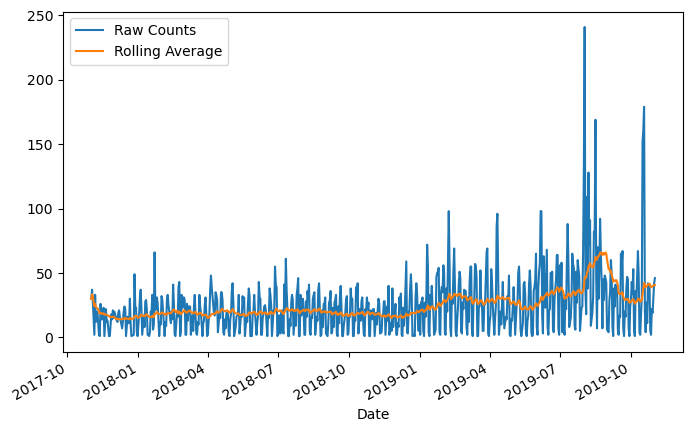

In [210]:
ax = missed_pickups_by_day.plot(x='Date', y='Num_Missed_Pickups', label= 'Raw Counts')
missed_pickups_by_day.plot(x='Date', y='rolling_30D', label= 'Rolling Average', ax=ax, figsize=(8, 5));

**Step 3: Main Task – 180-Day Rolling Fine Calculation**  
Metro Nashville charges fines for excessive missed trash pickups. It uses the following method to calculate the total fine:  A $1500 fine is charged for each missed pickup that is the third or subsequent one at the same address within a 180-day window. Multiple fines may apply to the same address.  
What is the total fine across all addresses? **Hint:** The rolling method can be use in combination with groupby.

In [213]:
# Clean up addresses
trash_misses = trash_misses.dropna(subset=['Incident Address'])
trash_misses['Incident Address'] = trash_misses['Incident Address'].str.upper()
trash_misses['Incident Address'] = trash_misses['Incident Address'].str.split(',', expand=True)[0]

In [215]:
# Convert Date column to datetime
trash_misses['Date'] = pd.to_datetime(trash_misses['Date'])
# Drop Metro trash misses, only include third parties
trash_misses_third_party = trash_misses[(trash_misses['Trash Hauler']=='RED RIVER') | (trash_misses['Trash Hauler']=='WASTE IND')]
total_fine = (trash_misses_third_party.groupby('Incident Address').rolling(window = '180D', on='Date')['Request Number'].count() >= 3).sum()*1500

In [216]:
print(f'The total fine across all addresses is ${total_fine:,.2f}.')

The total fine across all addresses is $2,241,000.00.


**Step 4: Bonus Questions**
* What other types of complaints are there?
* Are there any geospatial patterns?
* How do metro crews compare to the contractor's performance?
* How much does each trash hauler owe?
* What were the total missed pickup by route?

In [170]:
print('The types of complaints are the following:')
for complaint in trash_misses['Request'].unique():
    print(complaint)

The types of complaints are the following:
Trash - Curbside/Alley Missed Pickup
Trash Collection Complaint
Trash - Backdoor
Damage to Property


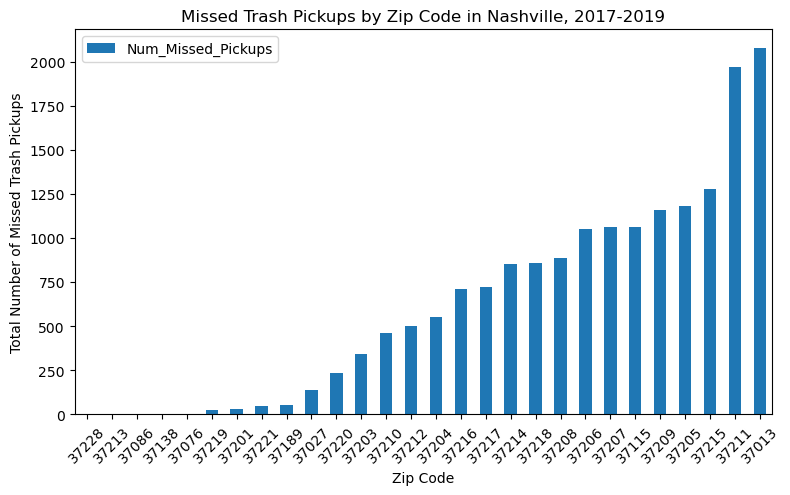

In [126]:
missed_pickups_by_zip = trash_misses.groupby('Zip Code').size().reset_index()
missed_pickups_by_zip.columns = ['Zip Code', 'Num_Missed_Pickups']
missed_pickups_by_zip['Zip Code'] = missed_pickups_by_zip['Zip Code'].astype('int')
missed_pickups_by_zip = missed_pickups_by_zip.sort_values(by='Num_Missed_Pickups')
missed_pickups_by_zip.plot(kind='bar', x='Zip Code', y='Num_Missed_Pickups', rot=45, figsize=(9, 5))
plt.title('Missed Trash Pickups by Zip Code in Nashville, 2017-2019')
plt.xlabel('Zip Code')
plt.ylabel('Total Number of Missed Trash Pickups')
plt.show()

Most trash pickup misses happen in the 37211 and 37013 Zip Codes, which represent the Antioch and 'Brentioch' areas.

In [131]:
third_parties=['RED RIVER', 'WASTE IND']
for third_party in third_parties:
    trash_misses_third_party = trash_misses[trash_misses['Trash Hauler']==third_party]
    total_fine = (trash_misses_third_party.groupby('Incident Address').rolling(window = '180D', on='Date')['Request Number'].count() >= 3).sum()*1500
    print(f'{third_party} owes ${total_fine:,.2f} to the Metro Nashville government.')

RED RIVER owes $1,632,000.00 to the Metro Nashville government.
WASTE IND owes $87,000.00 to the Metro Nashville government.


In [152]:
trash_misses_by_hauler = trash_misses.dropna(subset=['Trash Hauler'])

In [153]:
trash_misses_by_hauler['Trash Hauler'] = trash_misses_by_hauler['Trash Hauler'].str.upper()

/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_74982/1621867421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_misses_by_hauler['Trash Hauler'] = trash_misses_by_hauler['Trash Hauler'].str.upper()


In [154]:
trash_misses_metro = trash_misses_by_hauler[trash_misses_by_hauler['Trash Hauler']=='METRO']['Request Number'].count()

In [158]:
trash_misses_contractor = trash_misses_by_hauler[~(trash_misses_by_hauler['Trash Hauler']=='METRO')]['Request Number'].count()

In [163]:
print(f'Between 2017 and 2019, Metro Nashville had {trash_misses_metro:,} trash pickup misses, while third party contractors were responsible for {trash_misses_contractor:,} trash pickup misses.')

Between 2017 and 2019, Metro Nashville had 2,976 trash pickup misses, while third party contractors were responsible for 13,622 trash pickup misses.


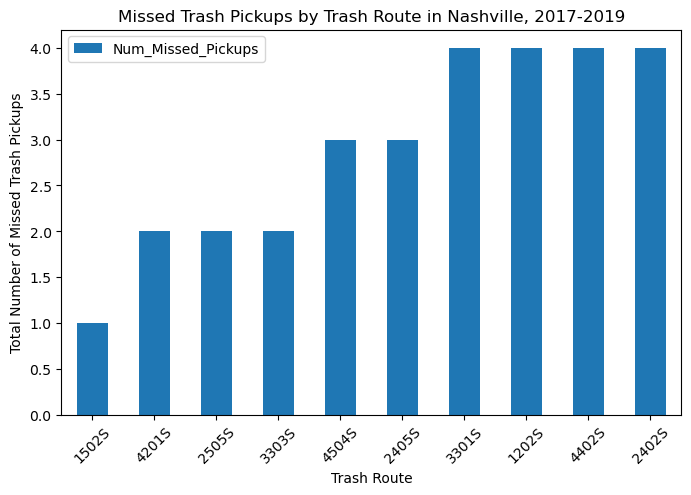

In [168]:
missed_pickups_by_route = trash_misses.groupby('Trash Route').size().reset_index()
missed_pickups_by_route.columns = ['Trash Route', 'Num_Missed_Pickups']
missed_pickups_by_route = missed_pickups_by_route.sort_values(by='Num_Missed_Pickups').head(10)
missed_pickups_by_route.plot(kind='bar', x='Trash Route', y='Num_Missed_Pickups', rot=45, figsize=(8, 5))
plt.title('Missed Trash Pickups by Trash Route in Nashville, 2017-2019')
plt.xlabel('Trash Route')
plt.ylabel('Total Number of Missed Trash Pickups')
plt.show()

The 2402S, 4402S, 1202S, and 3301S routes have the highest number of missed pickups, at 4 missed pickups apiece.